In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

import os
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split

In [36]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()

In [37]:
x_train = np.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = np.pad(x_test, [[0, 0], [2,2], [2,2]])/255

In [39]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train = np.repeat(x_train, 3, axis=3)
x_test = np.repeat(x_test, 3, axis=3)

In [40]:


#x_train = x_train.unsqueeze(3)
#x_train = x_train.repeats(3, axis=3)
                          
#x_train = tf.expand_dims(x_train, axis=3, name=None)
#x_test = tf.expand_dims(x_test, axis=3, name=None)
#x_train = tf.repeat(x_train, 3, axis=3)
#x_test = tf.repeat(x_test, 3, axis=3)

x_val = x_train[600:620,:,:]
y_val = y_train[600:620]
x_train = x_train[:600,:,:]
y_train = y_train[:600]

x_test = x_train[:100,:,:]
y_test = y_train[:100]



In [41]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(600).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(256)

In [42]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [43]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [44]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.summary()

In [46]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [47]:
history = model.fit(dataset, validation_data=test_dataset, batch_size=64, epochs=40)

Epoch 1/40
3/3 [==============================] - 4s 446ms/step - loss: 3.6848 - dense_14_loss: 2.3033 - dense_11_loss: 2.3021 - dense_13_loss: 2.3027 - dense_14_accuracy: 0.1350 - dense_11_accuracy: 0.1267 - dense_13_accuracy: 0.0850 - val_loss: 3.6750 - val_dense_14_loss: 2.2977 - val_dense_11_loss: 2.2932 - val_dense_13_loss: 2.2978 - val_dense_14_accuracy: 0.1400 - val_dense_11_accuracy: 0.0600 - val_dense_13_accuracy: 0.1400
Epoch 2/40
3/3 [==============================] - 0s 97ms/step - loss: 3.6790 - dense_14_loss: 2.3033 - dense_11_loss: 2.2931 - dense_13_loss: 2.2927 - dense_14_accuracy: 0.1317 - dense_11_accuracy: 0.1317 - dense_13_accuracy: 0.1400 - val_loss: 3.6708 - val_dense_14_loss: 2.2983 - val_dense_11_loss: 2.2807 - val_dense_13_loss: 2.2942 - val_dense_14_accuracy: 0.1400 - val_dense_11_accuracy: 0.0600 - val_dense_13_accuracy: 0.0600
Epoch 3/40
3/3 [==============================] - 0s 97ms/step - loss: 3.6690 - dense_14_loss: 2.2957 - dense_11_loss: 2.2850 - dense

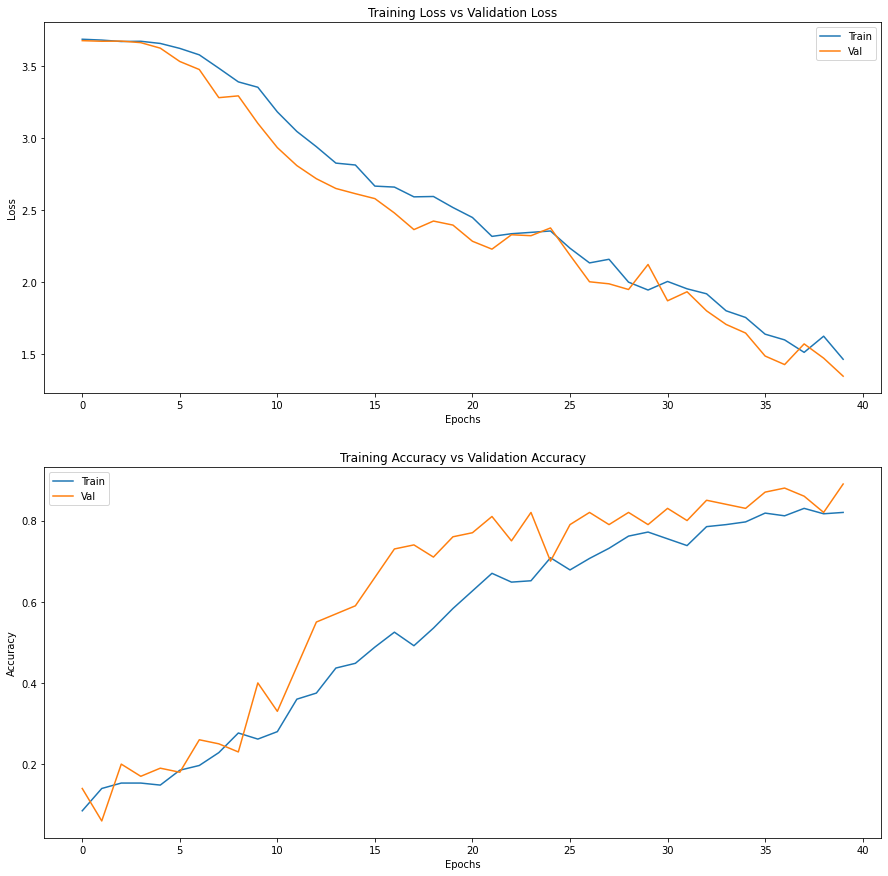

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_13_accuracy'])
axs[1].plot(history.history['val_dense_13_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [49]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 11ms/step - loss: 1.3445 - dense_14_loss: 1.1641 - dense_11_loss: 0.2426 - dense_13_loss: 0.3589 - dense_14_accuracy: 0.6200 - dense_11_accuracy: 0.9200 - dense_13_accuracy: 0.8900


[1.3444931507110596,
 1.1640522480010986,
 0.2426152229309082,
 0.35885438323020935,
 0.6200000047683716,
 0.9200000166893005,
 0.8899999856948853]

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [51]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

In [53]:
perturbations = create_adversarial_pattern(x_test, [y_test,y_test,y_test])

(32, 32, 3)


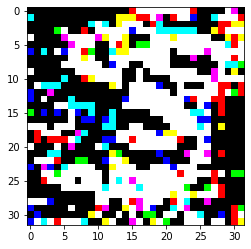

In [56]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

print(np.shape(perturbations[0]))

In [59]:
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
for i, eps in enumerate(epsilons):
  x_test = x_test+eps*perturbations
  x_test = tf.convert_to_tensor(x_test, tf.float32, name='t')
  model.evaluate(x_test, y_test)


4/4 [==============================] - 0s 11ms/step - loss: 70.4878 - dense_14_loss: 30.1442 - dense_11_loss: 66.6502 - dense_13_loss: 67.8284 - dense_14_accuracy: 0.1100 - dense_11_accuracy: 0.0600 - dense_13_accuracy: 0.0600
